In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
import time
import os
from typing import Dict, List, Tuple
from tensorflow.keras import layers, models
from typing import List, Dict, Tuple, Optional
from pathlib import Path



In [2]:
df = pd.read_csv("/Users/sohinikar/FL/M.Tech_Dissertation/Obfuscated-MalMem2022_train_and_test.csv")
df.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
1,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
2,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign
4,Benign,40,12,13.800000,0,306.950000,2082,52.050000,12278,306.950000,...,222,26,27,118,0,123,88,0,8,Benign


In [3]:
df.shape

(52708, 57)

In [4]:
df.describe()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
count,52708.000000,52708.000000,52708.000000,52708.0,52708.000000,52708.000000,52708.000000,5.270800e+04,52708.000000,52708.0,...,52708.000000,52708.000000,52708.000000,52708.000000,52708.000000,52708.0,52708.000000,52708.000000,52708.000000,52708.000000
mean,41.398972,14.721731,11.338282,0.0,247.386149,1810.511023,43.694839,1.025501e+04,249.447942,0.0,...,391.341011,221.405916,25.996338,25.059308,116.877552,0.0,121.994574,86.903127,0.000797,7.999886
std,5.779682,2.655174,1.587059,0.0,116.714088,329.846663,5.737274,5.066323e+03,153.023360,0.0,...,4.522731,1.985979,0.165994,1.528529,1.553418,0.0,2.825147,3.134089,0.028217,0.010669
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,94.000000,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000
25%,40.000000,12.000000,9.971429,0.0,208.700000,1556.000000,38.829268,8.393000e+03,209.634146,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000
50%,41.000000,15.000000,11.000000,0.0,243.759132,1730.000000,42.731409,9.275500e+03,246.794279,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000
75%,43.000000,16.000000,12.858038,0.0,289.728806,2087.000000,49.563324,1.219200e+04,291.287373,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000


In [5]:
df.shape

(52708, 57)

# Data Cleaning

In [6]:
# checking all the values in the columns are indetical
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"All values in {column} are identical.")

All values in pslist.nprocs64bit are identical.
All values in handles.nport are identical.
All values in svcscan.interactive_process_services are identical.


In [7]:
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
#checking for columns with null values

null_columns = df.columns[df.isnull().any()]
print("Columns with nulls:", list(null_columns))

Columns with nulls: []


# Encoding

In [9]:
df['Class'] = df['Class'].map({'Benign': 0, 'Malware': 1}) if df['Class'].dtype == 'object' else df['Class']

# sanity check of data before splitting

In [10]:
print("\nData Info:")
print(df.info())
print("\nFirst Few Rows:")
print(df.head())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52708 entries, 0 to 52707
Data columns (total 54 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                52708 non-null  object 
 1   pslist.nproc                            52708 non-null  int64  
 2   pslist.nppid                            52708 non-null  int64  
 3   pslist.avg_threads                      52708 non-null  float64
 4   pslist.avg_handlers                     52708 non-null  float64
 5   dlllist.ndlls                           52708 non-null  int64  
 6   dlllist.avg_dlls_per_proc               52708 non-null  float64
 7   handles.nhandles                        52708 non-null  int64  
 8   handles.avg_handles_per_proc            52708 non-null  float64
 9   handles.nfile                           52708 non-null  int64  
 10  handles.nevent                          52708 

In [11]:
print("DataFrame Shape:", df.shape)
print("Class Distribution:", df["Class"].value_counts())

DataFrame Shape: (52708, 54)
Class Distribution: Class
1    26388
0    26320
Name: count, dtype: int64


In [12]:
X = df.drop(columns=['Class','Category'])
y = df["Class"]

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Steep rise initially:
The first ~10 components capture a large portion of the total variance — roughly 90–95%.
This means most of the useful information is concentrated in those first few components.

Elbow point (approx at component 10–15):
After ~15 components, the curve flattens — additional components add very little new information (variance).

Plateau near 1.0:
Around 20–25 components, you reach nearly 100% variance retained, so including more components beyond that is redundant.

# Splitting the data

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=7)

In [15]:
X_test.shape

(15813, 52)

# Feedforward Neural Network for Binary Classification (FNN-BC)

In [16]:
early_stop = EarlyStopping(
    monitor="accuracy",      # or "val_accuracy"
    mode="max",
    patience=0,              # stop as soon as it stops improving
    min_delta=0.0,           # minimum change
    verbose=1
)

In [17]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(52,)),  # 52 input features
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 1
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 2
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')  # output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # optimizer
    loss='binary_crossentropy',            # binary classification loss
    metrics=['accuracy', tf.keras.metrics.Recall()]  # metrics
)

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
full_start = time.time()
model.fit(X_train, y_train,
          epochs=30,
          batch_size=64,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")

Epoch 1/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 3:49 398ms/step - accuracy: 0.3125 - loss: 1.4247 - recall: 0.1714

112/577 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.4352 - loss: 1.1412 - recall: 0.3873  

270/577 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.5034 - loss: 0.9710 - recall: 0.4732

429/577 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.5500 - loss: 0.8727 - recall: 0.5341

577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - accuracy: 0.5824 - loss: 0.8077 - recall: 0.5775


Epoch 2/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7656 - loss: 0.3553 - recall: 0.7879

155/577 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.8293 - loss: 0.3405 - recall: 0.9110

312/577 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - accuracy: 0.8391 - loss: 0.3293 - recall: 0.9153

470/577 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.8475 - loss: 0.3172 - recall: 0.9194

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - accuracy: 0.8521 - loss: 0.3095 - recall: 0.9217


Epoch 3/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8906 - loss: 0.2458 - recall: 0.9500

155/577 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.9052 - loss: 0.1940 - recall: 0.9471

312/577 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.9092 - loss: 0.1878 - recall: 0.9390

470/577 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.9119 - loss: 0.1839 - recall: 0.9320

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - accuracy: 0.9136 - loss: 0.1813 - recall: 0.9291


Epoch 4/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9531 - loss: 0.1288 - recall: 0.9091

157/577 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.9397 - loss: 0.1421 - recall: 0.9204

315/577 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.9386 - loss: 0.1432 - recall: 0.9205

473/577 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.9385 - loss: 0.1416 - recall: 0.9203

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.9387 - loss: 0.1400 - recall: 0.9202


Epoch 5/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9531 - loss: 0.0628 - recall: 0.9310

152/577 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9414 - loss: 0.1141 - recall: 0.9180

304/577 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.9421 - loss: 0.1218 - recall: 0.9199

459/577 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.9430 - loss: 0.1211 - recall: 0.9219

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - accuracy: 0.9434 - loss: 0.1197 - recall: 0.9231


Epoch 6/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9688 - loss: 0.0632 - recall: 0.9429

152/577 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9437 - loss: 0.0978 - recall: 0.9268

294/577 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.9458 - loss: 0.0957 - recall: 0.9297

444/577 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.9467 - loss: 0.0985 - recall: 0.9313

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.9471 - loss: 0.1005 - recall: 0.9320


Epoch 7/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9531 - loss: 0.1155 - recall: 0.9375

148/577 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - accuracy: 0.9598 - loss: 0.0789 - recall: 0.9486

296/577 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.9592 - loss: 0.0802 - recall: 0.9470

445/577 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.9587 - loss: 0.0815 - recall: 0.9464

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.9588 - loss: 0.0821 - recall: 0.9467


Epoch 8/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9375 - loss: 0.0910 - recall: 0.9000

153/577 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9587 - loss: 0.0767 - recall: 0.9427

303/577 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9589 - loss: 0.0763 - recall: 0.9443

455/577 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.9591 - loss: 0.0761 - recall: 0.9453

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - accuracy: 0.9595 - loss: 0.0769 - recall: 0.9461


Epoch 9/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9688 - loss: 0.0559 - recall: 0.9688

152/577 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9659 - loss: 0.0660 - recall: 0.9528

304/577 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.9652 - loss: 0.0662 - recall: 0.9529

457/577 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9650 - loss: 0.0682 - recall: 0.9532

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.9648 - loss: 0.0693 - recall: 0.9531


Epoch 10/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9375 - loss: 0.0555 - recall: 0.9630

156/577 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.9617 - loss: 0.0616 - recall: 0.9448

305/577 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9628 - loss: 0.0675 - recall: 0.9470

456/577 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.9634 - loss: 0.0684 - recall: 0.9479

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - accuracy: 0.9637 - loss: 0.0684 - recall: 0.9482


Epoch 11/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9375 - loss: 0.1998 - recall: 0.9459

152/577 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.9633 - loss: 0.0664 - recall: 0.9477

304/577 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.9639 - loss: 0.0650 - recall: 0.9473

457/577 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9643 - loss: 0.0649 - recall: 0.9470

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - accuracy: 0.9646 - loss: 0.0652 - recall: 0.9470


Epoch 12/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0224 - recall: 0.9655

152/577 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9714 - loss: 0.0525 - recall: 0.9557

306/577 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.9692 - loss: 0.0572 - recall: 0.9524

463/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9682 - loss: 0.0622 - recall: 0.9512

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.9677 - loss: 0.0650 - recall: 0.9507


Epoch 13/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0347 - recall: 1.0000

155/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9686 - loss: 0.0570 - recall: 0.9543

307/577 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - accuracy: 0.9672 - loss: 0.0596 - recall: 0.9508

462/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9667 - loss: 0.0604 - recall: 0.9490

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - accuracy: 0.9663 - loss: 0.0609 - recall: 0.9480


Epoch 13: early stopping


Training time = 3.086 seconds


## LSTM-BC: Long Short-Term Memory for Binary Classification

In [19]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [20]:
y_train = np.asarray(y_train).astype(np.float32)
y_test  = np.asarray(y_test).astype(np.float32)

In [21]:
lstm_bc = tf.keras.Sequential([
    tf.keras.Input(shape=(1, 52)),                # (timesteps, 52 features)
    tf.keras.layers.LSTM(13, activation='relu'),     # outputs 13-d vector
    tf.keras.layers.Dense(1, activation='sigmoid')   # binary output
])

lstm_bc.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

lstm_bc.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 13)             │         3,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,446 (13.46 KB)

 Trainable params: 3,446 (13.46 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
full_start = time.time()
lstm_bc.fit(X_train_lstm, y_train,
          epochs=30,
          batch_size=64,
          verbose=1,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")


Epoch 1/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4:36 480ms/step - accuracy: 0.3281 - loss: 0.8134 - recall: 0.0000e+00

 95/577 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.6431 - loss: 0.6452 - recall: 0.3477      

217/577 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.7794 - loss: 0.5280 - recall: 0.5953

341/577 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.8356 - loss: 0.4425 - recall: 0.6996

465/577 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.8667 - loss: 0.3825 - recall: 0.7576

577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.8854 - loss: 0.3424 - recall: 0.7923


Epoch 2/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0323 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9963 - loss: 0.0196 - recall: 0.9986

248/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9964 - loss: 0.0182 - recall: 0.9983

373/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9965 - loss: 0.0172 - recall: 0.9981

498/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9966 - loss: 0.0170 - recall: 0.9979

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.9966 - loss: 0.0171 - recall: 0.9978


Epoch 3/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0281 - recall: 1.0000

122/577 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.9968 - loss: 0.0102 - recall: 0.9965

246/577 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9974 - loss: 0.0089 - recall: 0.9969

370/577 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9977 - loss: 0.0094 - recall: 0.9971

494/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9978 - loss: 0.0101 - recall: 0.9972

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9979 - loss: 0.0102 - recall: 0.9973


Epoch 4/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0114 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.9988 - loss: 0.0056 - recall: 0.9990

247/577 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9988 - loss: 0.0076 - recall: 0.9989

366/577 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.9987 - loss: 0.0088 - recall: 0.9988

489/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9987 - loss: 0.0090 - recall: 0.9987

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.9987 - loss: 0.0089 - recall: 0.9987


Epoch 5/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0018 - recall: 1.0000

121/577 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.9993 - loss: 0.0314 - recall: 0.9993

245/577 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.9992 - loss: 0.0216 - recall: 0.9993

368/577 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9991 - loss: 0.0173 - recall: 0.9992

490/577 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9991 - loss: 0.0149 - recall: 0.9992

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.9991 - loss: 0.0137 - recall: 0.9991


Epoch 6/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 4.2543e-04 - recall: 1.0000

122/577 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.9995 - loss: 0.0022 - recall: 0.9993  

246/577 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9995 - loss: 0.0024 - recall: 0.9994

366/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9994 - loss: 0.0025 - recall: 0.9994

474/577 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.9994 - loss: 0.0028 - recall: 0.9994

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.9993 - loss: 0.0033 - recall: 0.9994


Epoch 7/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 0.0071 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9996 - loss: 0.0022 - recall: 0.9994

247/577 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9995 - loss: 0.0024 - recall: 0.9995

372/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9995 - loss: 0.0031 - recall: 0.9995

496/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9994 - loss: 0.0035 - recall: 0.9994

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9993 - loss: 0.0037 - recall: 0.9994


Epoch 8/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 3.2895e-04 - recall: 1.0000

124/577 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9998 - loss: 0.0019 - recall: 0.9998  

249/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9997 - loss: 0.0026 - recall: 0.9996

374/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9996 - loss: 0.0032 - recall: 0.9996

499/577 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.9995 - loss: 0.0034 - recall: 0.9995

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.9995 - loss: 0.0035 - recall: 0.9995


Epoch 9/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0086 - recall: 1.0000

122/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9992 - loss: 0.0030 - recall: 0.9993

246/577 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.9993 - loss: 0.0026 - recall: 0.9994

370/577 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9993 - loss: 0.0025 - recall: 0.9995

494/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9992 - loss: 0.0026 - recall: 0.9994

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.9992 - loss: 0.0026 - recall: 0.9994


Epoch 10/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0390 - recall: 1.0000

124/577 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9984 - loss: 0.0042 - recall: 0.9989

249/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9988 - loss: 0.0035 - recall: 0.9991

375/577 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.9989 - loss: 0.0035 - recall: 0.9992

501/577 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.9989 - loss: 0.0035 - recall: 0.9993

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.9990 - loss: 0.0034 - recall: 0.9993


Epoch 11/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 2.3346e-04 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9995 - loss: 0.0024 - recall: 1.0000  

248/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9994 - loss: 0.0024 - recall: 0.9999

372/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9993 - loss: 0.0024 - recall: 0.9998

496/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9993 - loss: 0.0023 - recall: 0.9997

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.9993 - loss: 0.0023 - recall: 0.9997


Epoch 12/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 1.9184e-04 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9995 - loss: 0.0012 - recall: 0.9992  

248/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9995 - loss: 0.0015 - recall: 0.9993

373/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9995 - loss: 0.0017 - recall: 0.9993

497/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9995 - loss: 0.0017 - recall: 0.9994

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.9994 - loss: 0.0018 - recall: 0.9994


Epoch 13/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 4.7381e-04 - recall: 1.0000

121/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9990 - loss: 0.0025 - recall: 0.9989  

242/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9992 - loss: 0.0022 - recall: 0.9992

363/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9992 - loss: 0.0020 - recall: 0.9993

485/577 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.9992 - loss: 0.0020 - recall: 0.9993

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.9992 - loss: 0.0019 - recall: 0.9994


Epoch 13: early stopping


Training time = 3.758 seconds


  1/495 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 1.0000 - loss: 1.6132e-04 - recall: 1.0000

184/495 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - accuracy: 0.9983 - loss: 0.0078 - recall: 0.9991    

390/495 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.9980 - loss: 0.0087 - recall: 0.9987

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.9981 - loss: 0.0085 - recall: 0.9986


Test Loss: 0.0071
Test Accuracy: 0.9982
Test precision: 0.9986
  1/495 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step

321/495 ━━━━━━━━━━━━━━━━━━━━ 0s 157us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7894
         1.0       1.00      1.00      1.00      7919

    accuracy                           1.00     15813
   macro avg       1.00      1.00      1.00     15813
weighted avg       1.00      1.00      1.00     15813



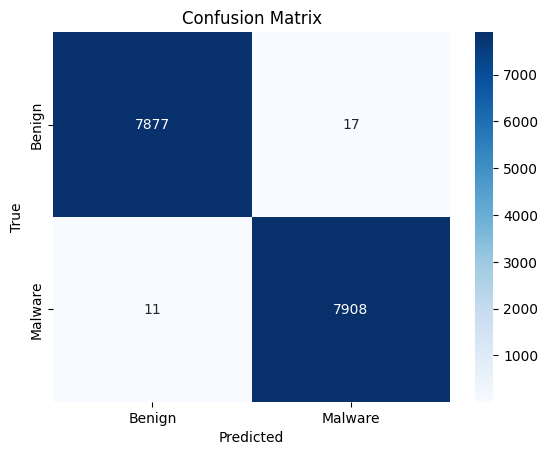

In [23]:
loss, acc , precision= model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


  1/495 ━━━━━━━━━━━━━━━━━━━━ 1:31 184ms/step - accuracy: 1.0000 - loss: 1.8123e-04 - recall: 1.0000

140/495 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.9985 - loss: 0.0027 - recall: 0.9993      

324/495 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - accuracy: 0.9986 - loss: 0.0028 - recall: 0.9992

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.9988 - loss: 0.0026 - recall: 0.9993


Test Loss: 0.0020
Test Accuracy: 0.9992
Test precision: 0.9994


  1/495 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step

263/495 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7894
         1.0       1.00      1.00      1.00      7919

    accuracy                           1.00     15813
   macro avg       1.00      1.00      1.00     15813
weighted avg       1.00      1.00      1.00     15813



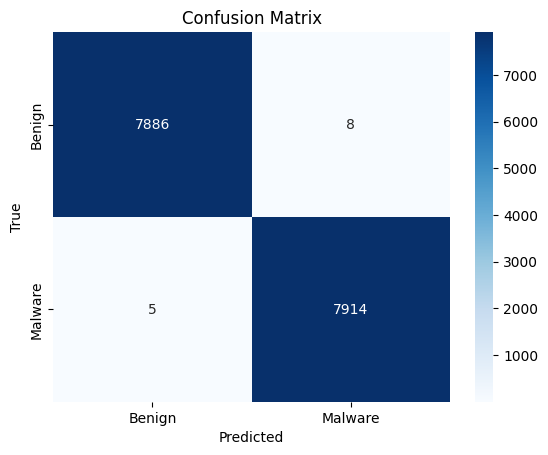

In [24]:
loss, acc , precision= lstm_bc.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (lstm_bc.predict(X_test_lstm) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Save full model (preferred modern way)
model.save("global_FNN_model.keras")
lstm_bc.save("global_lstm_model.keras")